In [1]:
if(!require("devtools"))
{
    install.packages("devtools")      
}
library(devtools)

Loading required package: devtools

Loading required package: usethis



In [2]:
if(system.file(package='changed') != '')
{
    remove.packages("changed")
}
install_github("grosed/changed/R/package@dev")

Removing package from ‘/home/grosedj/work/changed-env/R-packages’
(as ‘lib’ is unspecified)





── R CMD build ─────────────────────────────────────────────────────────────────
✔  checking for file ‘/tmp/Rtmp9z2HuA/remotes100f7a4921c82/grosed-changed-cff1b6b/R/package/DESCRIPTION’
─  preparing ‘changed’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
     NB: this package now depends on R (>= 3.5.0)
     serialize/load version 3 cannot be read in older versions of R.
     File(s) containing such objects:
       ‘changed/tests/testthat/test.data.RData’
─  building ‘changed_1.0.tar.gz’
   


Installing package into ‘/home/grosedj/work/changed-env/R-packages’
(as ‘lib’ is unspecified)



In [3]:
library(changed)

In [4]:
set.seed(0) 

singmean <- c(rnorm(100,0,1),rnorm(100,10,1))
mulmean <- c(rnorm(100,0,1),rnorm(100,10,1),rnorm(100,20,1),rnorm(100,50,1))
nochange <- c(rnorm(200,0,1))
singvar <- c(rnorm(100,10,1),rnorm(100,10,5))
mulvar <- c(rnorm(100,20,10),rnorm(100,20,15),rnorm(100,20,20),rnorm(100,20,25))
singmeanvar <- c(rnorm(50,0,1),rnorm(50,3,10))
mulmeanvar <- c(rnorm(50,0,1),rnorm(50,5,3),rnorm(50,10,1),rnorm(50,3,10))
mulmeanvarexp <- c(rexp(50,1), rexp(50,3), rexp(50,5), rexp(50,7)) 
mulmeanvarpois <- c(rpois(50,1), rpois(50,2), rpois(50,3), rpois(50,5)) 
constant <- rep(1, 200)

testdata <- list("singmean" = singmean,
                 "mulmean" = mulmean, 
                 "nochange" = nochange, 
                 "singvar" = singvar, 
                 "mulvar" = mulvar, 
                 "singmeanvar" = singmeanvar,
                 "mulmeanvar" = mulmeanvar, 
                 "mulmeanvarexp" = mulmeanvarexp, 
                 "mulmeanvarpois" = mulmeanvarpois,
                 "constant" = constant) 

In [5]:
### a sequence of quantiles
qnt.seq <- function(x, K=NULL, method="nonequally"){
  
  n <- length(x)
  if(is.null(K)){
    K <- round(4*log(n))
  }
  Q <- matrix(0, K, n+1)
  sorted.x = sort(x)
  yK = -1 + (2*(1:K)/K-1/K)
  c = -log(2*n-1)
  if(method=="equally"){
    pK = seq(0, 1, length.out = K+2)[-c(1, K+2)]
  }else{
    pK  = (1+exp(c*yK))^-1
  }
  
  qnt = rep(NA, K)
  for (i in 1:K){
    j  = as.integer((n-1)*pK[i] + 1)
    qnt[i] = sorted.x[j]
  }
  return(qnt)
  
}

In [6]:
res <- list()
for(data in testdata)
{
   Ks <- seq(2,60) 
   for(k in Ks)
       {
          qnts.hyeyoung <- c(-Inf,qnt.seq(data,k),Inf)
          qnts.changed <- quantiles(data,k,"non-equal")
          res <- c(res,all.equal(qnts.hyeyoung,qnts.changed))
       }
}

In [7]:
which(res==FALSE)

integer(0)

In [8]:
### minus log-likelihood
minloglik <- function(x, Q, i, j){
  
  if (i>=j) {
    min.log.lik <- 0 
  }else{
    t <- j-i+1
    mi <- sum(x[i:j] < Q) + 0.5*sum(x[i:j]==Q)
    
    if(mi==0 | mi==t){
      min.log.lik <- 0 
    }else{
      min.log.lik <- -mi*log(mi/t)-(t-mi)*log(1-mi/t) 
    }
    
  }
  
  return(min.log.lik)  
  
}

In [9]:
### cost function for PELT
costMatrix = function(x, qnt) {
  
  N = length(x)
  K = length(qnt)
  C <- array(NA, dim=c(length(qnt), N, N))
  
  for(k in 1:K){
    for (i in 1:N){
      for (j in 1:N){
        C[k, i, j] = minloglik(x=x, Q=qnt[k], i=i, j=j)
      }
    }
  }
  
  return(C)
}

In [10]:
costMatrix_c = function(x, qnt) {
  
  N = length(x)
  K = length(qnt)
  
  C = matrix(nr = N, nc = N)
  qnt0 = c(0, qnt, Inf)
  
  for (i in 1:N){
    
    for (j in 1:N){
      
      if (i>=j) {
        
        min.log.lik <- 0 
        
      }else{
        
        t <- j-i+1
        mi <- rep(NA, (length(qnt0)-1))
        f_mi <- rep(NA, (length(qnt0)-1))
        
        for(l in 1:(length(qnt0)-1)){
          
          mi[l] <- sum(((qnt0[l] < x[i:j])+(x[i:j] <= qnt0[l+1]))==2)
          
          if(mi[l]==0 | mi[l]==t){
            f_mi[l] <- 0 
          }else{
            f_mi[l] <- -mi[l]*log(mi[l]/t)
          }
          
        }
        
        min.log.lik <- sum(f_mi)
        
      }
      
      C[i, j] = min.log.lik
      
    }
  }
  
  return(C)
}

In [11]:
data <- singmean
k <- 40
qs <- qnt.seq(data,k)

In [12]:
cf <-new(changed::np_conditional)
cf$set(data,c(-Inf,qs,Inf))
cm.changed <- matrix(0,length(data),length(data))
for(i in 1:length(data))
    {
        for(j in 1:length(data))
        {
            cm.changed[i,j] <- cf$cost(i,j)
        }
    }
cm.hyeyoung <- costMatrix_c(data,qs)

In [13]:
all.equal(cm.hyeyoung,cm.changed)

[1] "Mean relative difference: 0.01110398"

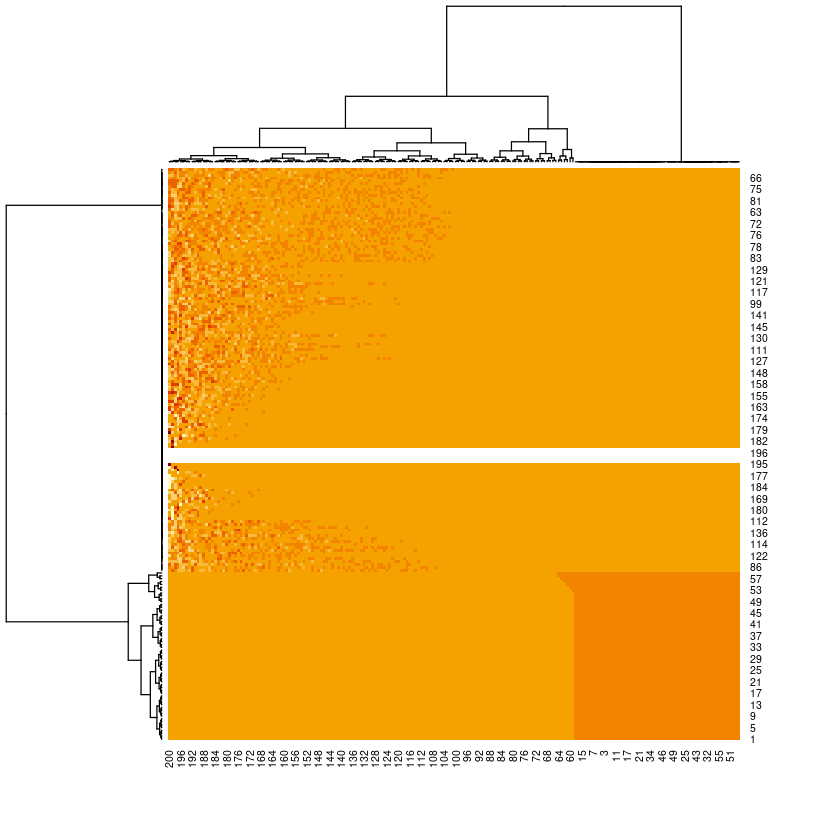

In [14]:
heatmap(cm.hyeyoung-cm.changed)

In [15]:
dm <- (cm.hyeyoung-cm.changed)/cm.hyeyoung
pos <- which(dm == max(dm,na.rm=TRUE), arr.ind = TRUE)
dm[pos[1,1],pos[1,2]]

[1] 6.761887e-16

In [16]:


cf_average <- function(C,i,j,N)
    {
      return((-2*log(2*N-1)*colMeans(-C[, i, j, drop=F]))[1,1])
    }
cf <-new(changed::np_average)
cf$set(data,c(-Inf,qs,Inf))
cm.changed <- matrix(0,length(data),length(data))
cm.hyeyoung <- matrix(0,length(data),length(data))
cm <- costMatrix(data,qs)
n <- length(data)
for(i in 1:length(data))
    {
        for(j in 1:length(data))
        {
            cm.changed[i,j] <- cf$cost(i,j)
            cm.hyeyoung[i,j] <- cf_average(cm,i,j,n)
        }
    }

In [17]:
all.equal(cm.hyeyoung,cm.changed)

[1] TRUE

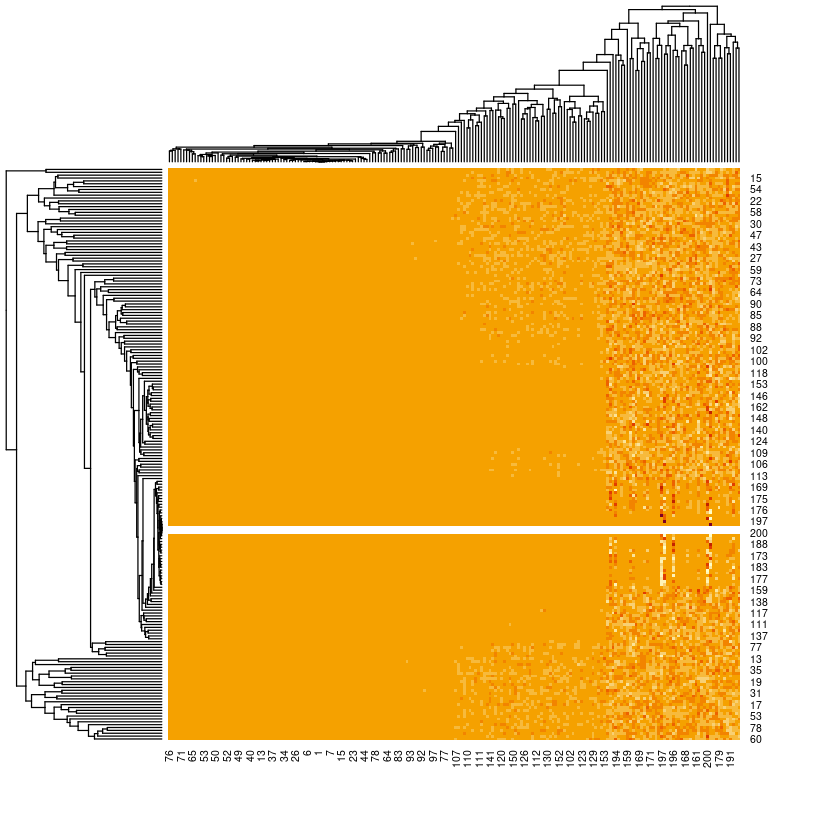

In [18]:
heatmap(cm.hyeyoung-cm.changed)

In [19]:
dm <- (cm.hyeyoung-cm.changed)/cm.hyeyoung
pos <- which(dm == max(dm,na.rm=TRUE), arr.ind = TRUE)
dm[pos[1,1],pos[1,2]]

[1] 8.912595e-16

In [20]:

cf_max <- function(C,i,j)
    {
    return(apply(2*C[, i, j, drop=F], 2, max))
    }
cf <-new(changed::np_max)
cf$set(data,c(-Inf,qs,Inf))
cm.changed <- matrix(0,length(data),length(data))
cm.hyeyoung <- matrix(0,length(data),length(data))
cm <- costMatrix(data,qs)
n <- length(data)
for(i in 1:length(data))
    {
        for(j in 1:length(data))
        {
            cm.changed[i,j] <- cf$cost(i,j)
            cm.hyeyoung[i,j] <- cf_max(cm,i,j)
        }
    }

In [21]:
all.equal(cm.hyeyoung,cm.changed)

[1] TRUE

Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”


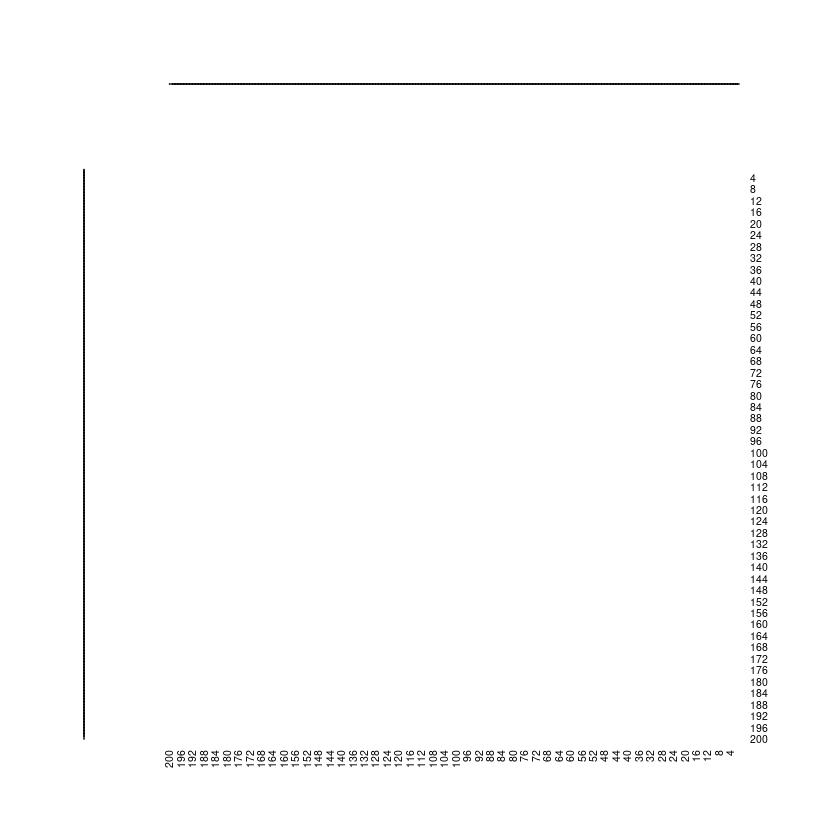

In [22]:
heatmap(cm.hyeyoung-cm.changed)

In [23]:
dm <- (cm.hyeyoung-cm.changed)/cm.hyeyoung
pos <- which(dm == max(dm,na.rm=TRUE), arr.ind = TRUE)
dm[pos[1,1],pos[1,2]]

[1] 0